In [49]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image

# Part I: Convolutional Neural networks with MNIST

In [ ]:
# Load the data from MNIST
(train_feats, train_labels), (valid_feats, valid_labels) = mnist.load_data()
train_feats.shape

# Since there is only a single channel in MNIST, we'll need to resize the data
img_rows = train_feats.shape[1]
img_cols = train_feats.shape[2]
train_feats = train_feats.reshape(train_feats.shape[0], img_rows, img_cols, 1)
valid_feats = valid_feats.reshape(valid_feats.shape[0], img_rows, img_cols, 1)
print('new shape:', train_feats.shape)

# let's make the labels categorical
train_labels = pd.get_dummies(train_labels)
valid_labels = pd.get_dummies(valid_labels)

train_feats = train_feats / 255
valid_feats = valid_feats / 255

# define loss & optimizer.  
# This time we will specify a learning rate for the Adam optimizer
loss = 'categorical_crossentropy'
opt = Adam(lr=.001)

### Define the Model

- The kernel_size parameter defines the shape of the filter.
- It is typical to double the size of the layer after halving the dimensionality using Max Pooling
- To show you how to define weight initialization, we'll set the initialization to "He Normal," described in the lecture.
- We will also add Dropout regularization
- We will include Batch Normalization after every layer, but before the activation function.  Which means we will define activations as their own layers rather than passing them in as parameters as before

In [ ]:
inputs = Input(shape=(28, 28, 1)) # 28 is the size of image, 1 is size of channel.

# 2 Convolutional layers each followed by max pooling
x = Conv2D(32, kernel_size=(5, 5), kernel_initializer='he_normal')(inputs) # he normal..
x = BatchNormalization()(x) # we want normalization to occur between initialization and activation.
x = Activation('relu')(x) 
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Here we'll add a single Dense layer before the prediction
x = Flatten()(x) # we have these tiny little feature maps, but we just have one giant vector (dense layer).
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

# this model is smaller than normal keras model. 225,000
# dense layers have fewer parametsr.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_feats, train_labels, epochs=5, batch_size=32,
         validation_data=(valid_feats, valid_labels))

# giving it 5 epochs because it is slow
# It is slower than keras model even though
# it has less layers. However, we are not just
# dot producting the matrix, but taking a dot
# product accross the whole dimension of the
# image. 

# feature maps can be seen



Questions to think about:  

1) Why does training this model take longer than training a fully-connected model from before, even though it has fewer parameters?

2) Why would there be higher accuracy / lower loss on the validation set?

# Part II:  Starting with a pretrained ImageNet model

Now we'll take a look at a beefier model, pretrained on imagenet.  Let's look at ResNet 50.  It will give us a chance to examine its architecture.  We won't train it since we don't have gpus, but we'll show how one would go about building an image classifier model that is pretrained on ImageNet.

If you are working with image data it's highly recommend you try using a pretrained model as a starting place.

In [7]:
resnet50 = applications.resnet50.ResNet50(include_top=True)

In [79]:
# resnet50.summary()

Big network!  Let's see what it thinks about some images

We'll load in a photo of Edinburgh castle, process it, and see what the model thinks it is
Keras has all these helpers already built

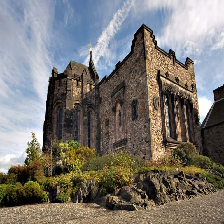

In [53]:
castle = image.load_img('../data/images/castle_images.jpg').resize((224, 224))
castle

In [57]:
# turn into a numpy array and preprocess
castle = image.img_to_array(castle)
castle = np.expand_dims(castle, axis=0)
castle = preprocess_input(castle)

In [59]:
# predict what the image is
preds = resnet50.predict([castle])
decode_predictions(preds)

40960/35363 [==================================] - 0s 2us/step


[[('n03028079', 'church', 0.5273485),
  ('n02980441', 'castle', 0.31995678),
  ('n03781244', 'monastery', 0.14112745),
  ('n04523525', 'vault', 0.0026836304),
  ('n03877845', 'palace', 0.0023600254)]]

Not bad!  It actually does look very churchy for a castle

### Use a pretrained image model on a different task

As fun as it is to use a model that can guess what's in a picture, What you may want this for is to train a data set on some task unrelated to ImageNet, but where you don't have enough data to get good representation of images.   

In that case you will want to access earlier model layers, as those outputs will be more abstract but likely still useful.  Let's say you want to train a model to predict one of three things unrelated to ImageNet.  We will access the _penultimate_ layer of ResNet, put another dense classifier on, and freeze the rest of ResNet so we don't alter the underlying model.  

You would do this if you were convinced that the model will already know useful features, or, as is likely the case, you don't have the computational capacity or time to train 25 million weights.  Alternatively you may also want to "fine tune" the underlying model as well, in which case don't freeze the layers.

In [75]:
# first lets freeze all the resnet layers so they can't be trained
for layer in resnet50.layers:
    layer.trainable=False

# index -2 is the penultimate layer.  "Flatten" from the summary above
embedding_layer = resnet50.get_layer(index=-2)
embedding_layer_out = embedding_layer.output
embedding_layer

In [78]:
# lets imagine you have three classes to predict
resnet50_input = resnet50.input
new_classification_output = Dense(3, activation='softmax')(embedding_layer_out)
new_model = Model(inputs=resnet50_input, outputs=new_classification_output)

# new_model.summary()

Now your new model is ready to train.   If you froze the resnet, you'll notice from the new model summary that there are only 6,000 trainable parameters instead of 25 million.  This model will train very quickly.

The less similar to ImageNet your task, the more low-level and abstract you may want the representations to be, so feel free to use earlier layers from the model as your "embedding" layer.  The farther back you go, the more abstract the feature maps